In [1]:
# cmd> docker pull stnb/fenics
# cmd> docker run -p 8888:8888 stnb/fenics
# ссылка на юпитер - в логах запущенного из приложения контейнера

In [2]:
from mshr import *
from fenics import *

import imageio
import numpy as np
import matplotlib
import matplotlib.tri as tri
import matplotlib.pyplot as plt

In [3]:
matplotlib.rcParams.update({'font.size': 18})

In [4]:
def calculate(V, exact_u, alpha, f, h, g, show = True):

    def is_left_boundary(x, on_boundary):
        return on_boundary and x[0] < 0

    bc = DirichletBC(V, h, is_left_boundary)

    u = TrialFunction(V)
    v = TestFunction(V)
    a = (dot(grad(u), grad(v)) + alpha * u * v) * dx
    L = f * v * dx + g * v * ds

    u = Function(V)
    solve(a == L, u, bc)

    error_L2 = errornorm(exact_u, u, 'L2')

    vertex_values_exact_u = exact_u.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_exact_u - vertex_values_u))
    
    if (show):
        print('error_L2  =', error_L2)
        print('error_max =', error_max)
        print("-" * 127)
    
    return u

In [5]:
########################################################## part 1 ##########################################################

In [6]:
def visualize(mesh, u, other_u, title):
    n = mesh.num_vertices()
    d = mesh.geometry().dim()
    mesh_coordinates = mesh.coordinates().reshape((n, d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
    plt.figure(figsize = (10, 8))
    zfaces = (np.asarray([u(cell.midpoint()) for cell in cells(mesh)]) if other_u == None
                else np.asarray([np.abs(u(cell.midpoint()) - other_u(cell.midpoint())) for cell in cells(mesh)]))
    plt.tripcolor(triangulation, facecolors = zfaces, edgecolors='k')
    plt.grid()
    plt.colorbar()
    plt.title(title)
    plt.plot()

error_L2  = 0.00021729271029891653
error_max = 0.00046690934200710466
-------------------------------------------------------------------------------------------------------------------------------


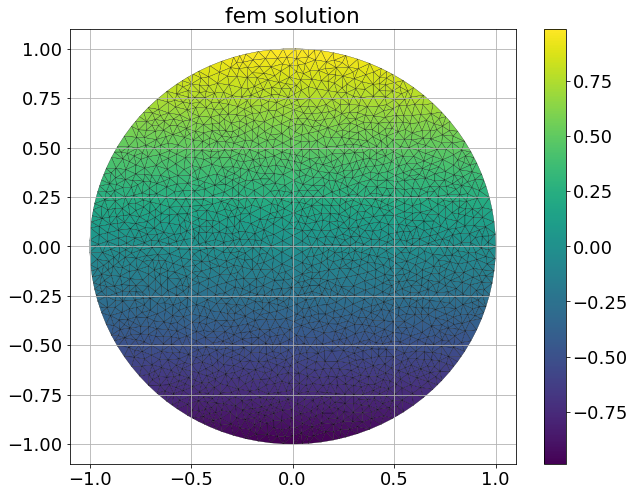

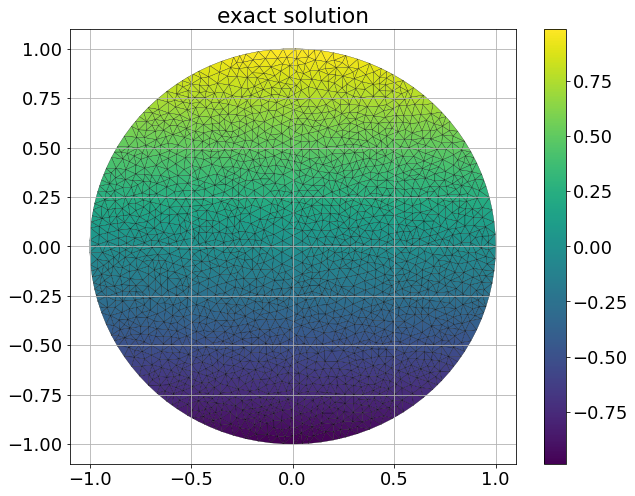

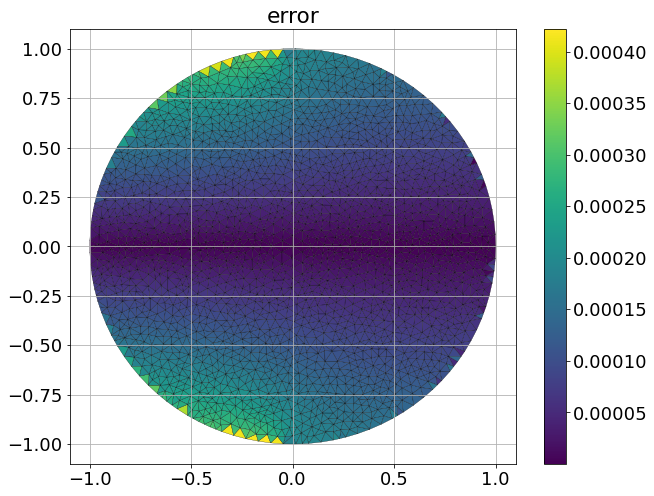

In [7]:
# test 1
# u = r * sin(phi) (= y), R = 1, alpha = 1

r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

domain = Circle(Point(0, 0), 1)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

exact_u = Expression("r * sin(phi)", r = r, phi = phi, degree = 2)
alpha = Constant(1)
f = Expression("alpha * r * sin(phi)", alpha = alpha, r = r, phi = phi, degree = 2)
h = Expression("1 * sin(phi)", phi = phi, degree = 2)
g = Expression("sin(phi)", phi = phi, degree = 2)

u = calculate(V, exact_u, alpha, f, h, g)

visualize(mesh, u, None, "fem solution")
visualize(mesh, exact_u, None, "exact solution")
visualize(mesh, u, exact_u, "error")

error_L2  = 0.1871406112408814
error_max = 0.17969660707576907
-------------------------------------------------------------------------------------------------------------------------------


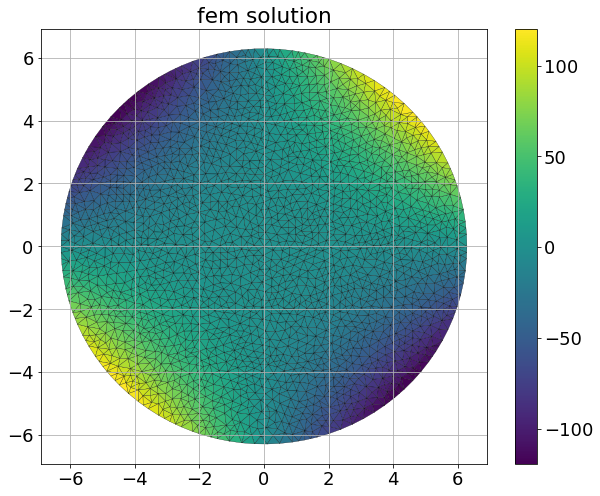

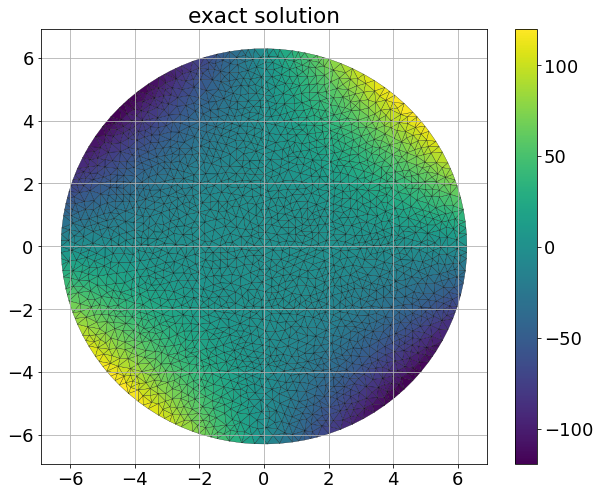

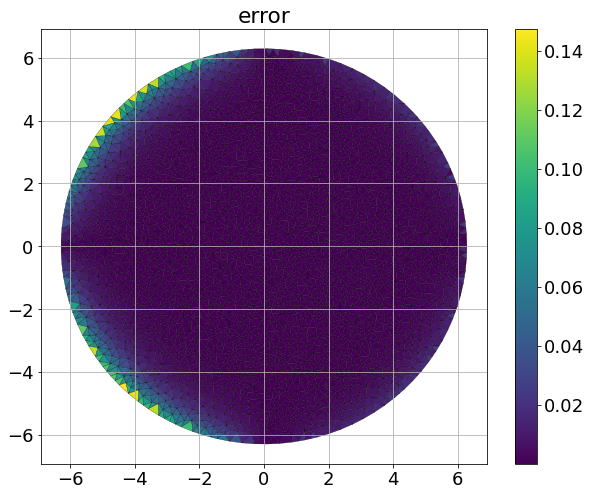

In [8]:
# test 2
# u = r ** 3 * cos(phi) * sin(phi), R = 2 * pi, alpha = 5

r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

domain = Circle(Point(0, 0), 2 * np.pi)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

exact_u = Expression("r * r * r * cos(phi) * sin(phi)", r = r, phi = phi, degree = 2)
alpha = Constant(5)
f = Expression("- 9 * r * cos(phi) * sin(phi) + 2 * r * sin(2 * phi) + alpha * r * r * r * cos(phi) * sin(phi)", 
               alpha = alpha, r = r, phi = phi, degree = 2)
h = Expression("8 * pi * pi * pi * cos(phi) * sin(phi)", phi = phi, degree = 2)
g = Expression("3 * 4 * pi * pi * cos(phi) * sin(phi)", phi = phi, degree = 2)

u = calculate(V, exact_u, alpha, f, h, g)

visualize(mesh, u, None, "fem solution")
visualize(mesh, exact_u, None, "exact solution")
visualize(mesh, u, exact_u, "error")

error_L2  = 233.04089874387566
error_max = 241.59726717480225
-------------------------------------------------------------------------------------------------------------------------------


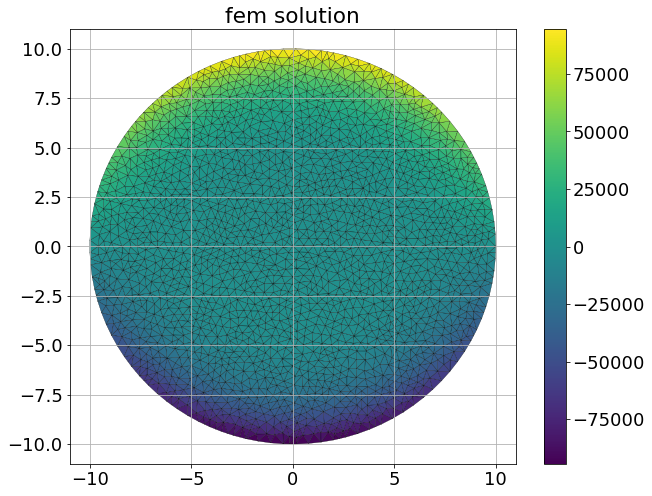

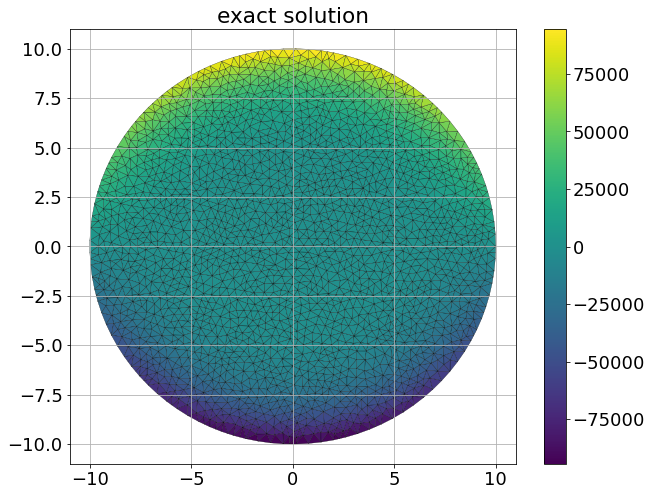

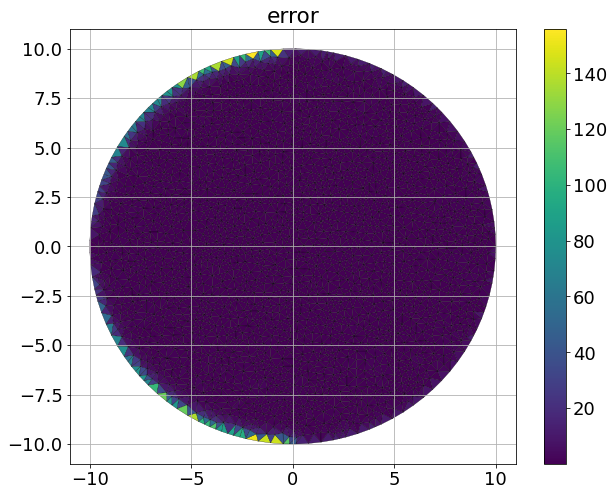

In [9]:
# test 3
# u = r ** 2 * cos(phi) + r ** 5 * sin(phi), R = 10, alpha = 20

r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

domain = Circle(Point(0, 0), 10)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

exact_u = Expression("r * r * cos(phi) + pow(r, 5) * sin(phi)", r = r, phi = phi, degree = 2)
alpha = Constant(20)
f = Expression("-3 * cos(phi) - 24 * r * r * r * sin(phi) + alpha * (r * r * cos(phi) + pow(r, 5) * sin(phi))", 
               alpha = alpha, r = r, phi = phi, degree = 2)
h = Expression("100 * cos(phi) + pow(10, 5) * sin(phi)", phi = phi, degree = 2)
g = Expression("20 * cos(phi) + 5 * pow(10, 4) * sin(phi)", phi = phi, degree = 2)

u = calculate(V, exact_u, alpha, f, h, g)

visualize(mesh, u, None, "fem solution")
visualize(mesh, exact_u, None, "exact solution")
visualize(mesh, u, exact_u, "error")

In [10]:
########################################################## part 2 ##########################################################

In [11]:
def visualize2(mesh, i, u, other_u, t, mn, mx, hide):
    cm = matplotlib.colors.LinearSegmentedColormap.from_list("", [[0.0, 0.0, 1.0],
                                                                  [0.0, 0.2, 0.8],
                                                                  [0.8, 0.6, 0.0],
                                                                  [0.8, 0.2, 0.0],
                                                                  [1.0, 0.0, 0.0]])
    n = mesh.num_vertices()
    d = mesh.geometry().dim()
    mesh_coordinates = mesh.coordinates().reshape((n, d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
    fig = plt.figure(figsize = (10, 8))
    zfaces = (np.asarray([u(cell.midpoint()) for cell in cells(mesh)]) if other_u == None
            else np.asarray([np.abs(u(cell.midpoint()) - other_u(cell.midpoint())) for cell in cells(mesh)]))
    plt.tripcolor(triangulation, facecolors = zfaces, edgecolors='k', cmap = cm)
    if mn != None and mx != None: 
        plt.clim(mn, mx)
    plt.grid()
    plt.title(t)
    bounds = np.linspace(mn, mx, 6)
    ax = fig.add_axes([0.92, 0.122, 0.05, 0.757])
    cb = matplotlib.colorbar.ColorbarBase(ax, orientation='vertical', cmap = cm, ticks = bounds, boundaries = bounds,
                                          norm=matplotlib.colors.Normalize(vmin=mn, vmax=mx))
    plt.plot()
    plt.savefig(f"fig_{i}.png", bbox_inches = "tight")
    if hide: plt.close()

In [12]:
def minimax(mesh, u_list):
    mn, mx = None, None
    for i, u in enumerate(u_list): 
        n = mesh.num_vertices()
        d = mesh.geometry().dim()
        mesh_coordinates = mesh.coordinates().reshape((n, d))
        zfaces = np.asarray([u(cell.midpoint()) for cell in cells(mesh)])
        
        mn1 = np.amin(zfaces)
        if (mn == None):
            mn = mn1
        elif (mn1 < mn):
            mn = mn1
            
        mx1 = np.amax(zfaces)
        if (mx == None):
            mx = mx1
        elif (mx1 > mx):
            mx = mx1
            
    return mn, mx

error_L2  = 0.012769861089249511
error_max = 0.014667964595584393
-------------------------------------------------------------------------------------------------------------------------------
error_L2  = 0.018210604863446094
error_max = 0.02105489597111207
-------------------------------------------------------------------------------------------------------------------------------
error_L2  = 0.02058725194313398
error_max = 0.023883409680806655
-------------------------------------------------------------------------------------------------------------------------------
error_L2  = 0.021650669711087773
error_max = 0.025158240522154096
-------------------------------------------------------------------------------------------------------------------------------
error_L2  = 0.022152020659759467
error_max = 0.02576242278111296
-------------------------------------------------------------------------------------------------------------------------------
error_L2  = 0.022417086420299815


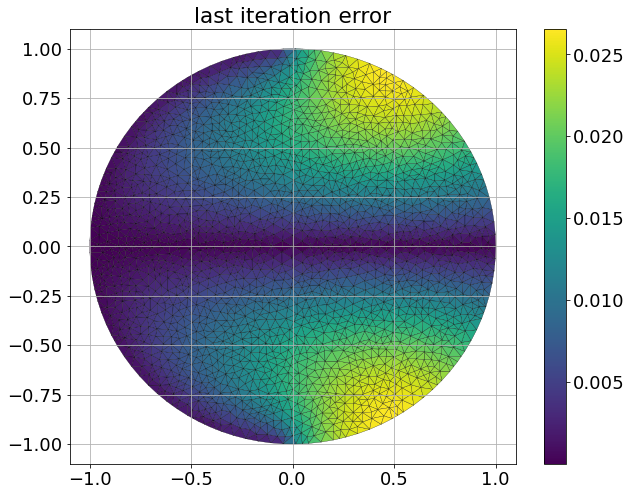

In [13]:
# test 1, u = t ** 2 * r * sin(phi)

domain = Circle(Point(0, 0), 1)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

T = 2.0
num_steps = 10
dt = T / num_steps

r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

t = 0
exact_u = Expression("t * t * r * sin(phi)", t = t, r = r, phi = phi, degree = 2)
param_a = Constant(1)
f = Expression("2 * t * r * sin(phi)", t = t, r = r, phi = phi, degree = 2)
h = Expression("t * t * 1 * sin(phi)", t = t, phi = phi, degree = 2)
g = Expression("t * t * sin(phi)", t = t, phi = phi, degree = 2)

u_n = interpolate(h, V)
u_list_fem = [u_n.copy()]
u_list_exact = [Expression("t * t * r * sin(phi)", t = t, r = r, phi = phi, degree = 2)]
for n in range(num_steps):
    t += dt
    exact_u.t = t
    f.t = t
    h.t = t
    g.t = t
    u = calculate(V, exact_u, 1.0 / (dt * param_a), u_n / (dt * param_a) + f / param_a, h, g)
    u_n.assign(u)
    u_list_fem.append(u_n.copy())
    u_list_exact.append(Expression("t * t * r * sin(phi)", t = t, r = r, phi = phi, degree = 2)) # deep copy doesn't work!
    
mn, mx = minimax(mesh, u_list_fem)

for i in range(num_steps):
    visualize2(mesh, i, u_list_fem[i], None, "fem solution, $u = t^2 r sin(φ)$", mn, mx, True)

with imageio.get_writer("_test_1_fem.gif", mode = 'i', duration = 0.3) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"fig_{i}.png")
        writer.append_data(image)
        
mn, mx = minimax(mesh, u_list_exact)        

for i in range(num_steps):
    visualize2(mesh, i, u_list_exact[i], None, "exact solution, $u = t^2 r sin(φ)$", mn, mx, True)

with imageio.get_writer("_test_1_exact.gif", mode = 'i', duration = 0.3) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"fig_{i}.png")
        writer.append_data(image)

visualize(mesh, u_list_fem[num_steps - 1], u_list_exact[num_steps - 1], "last iteration error")

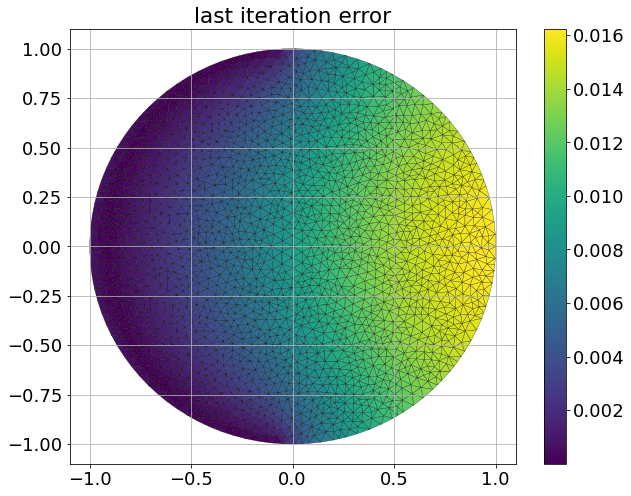

In [14]:
# test 2, u = r ** 2 * cos(phi) + 8 * t

domain = Circle(Point(0, 0), 1)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

T = 2.0
num_steps = 40
dt = T / num_steps

r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

t = 0
exact_u = Expression("r * r * cos(phi) + 8 * t", t = t, r = r, phi = phi, degree = 2)
param_a = Constant(1)
f = Expression("- 3 * cos(phi) + 8", phi = phi, degree = 2)
h = Expression("1 * 1 * cos(phi) + 8 * t", t = t, phi = phi, degree = 2)
g = Expression("2 * 1 * cos(phi)", phi = phi, degree = 2)

u_n = interpolate(h, V)
u_list_fem = [u_n.copy()]
u_list_exact = [Expression("r * r * cos(phi) + 8 * t", t = t, r = r, phi = phi, degree = 2)]
for n in range(num_steps):
    t += dt
    exact_u.t = t
    h.t = t
    u = calculate(V, exact_u, 1.0 / (dt * param_a), u_n / (dt * param_a) + f / param_a, h, g, False)
    u_n.assign(u)
    u_list_fem.append(u_n.copy())
    u_list_exact.append(Expression("r * r * cos(phi) + 8 * t", t = t, r = r, phi = phi, degree = 2))
    
mn, mx = minimax(mesh, u_list_fem)

for i in range(num_steps):
    visualize2(mesh, i, u_list_fem[i], None, "fem solution, $u = r^2 cos(φ) + 8t$", mn, mx, True)

with imageio.get_writer("_test_2_fem.gif", mode = 'i', duration = 0.2) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"fig_{i}.png")
        writer.append_data(image)
        
mn, mx = minimax(mesh, u_list_exact)        

for i in range(num_steps):
    visualize2(mesh, i, u_list_exact[i], None, "exact solution, $u = r^2 cos(φ) + 8t$", mn, mx, True)

with imageio.get_writer("_test_2_exact.gif", mode = 'i', duration = 0.2) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"fig_{i}.png")
        writer.append_data(image)

visualize(mesh, u_list_fem[num_steps - 1], u_list_exact[num_steps - 1], "last iteration error")

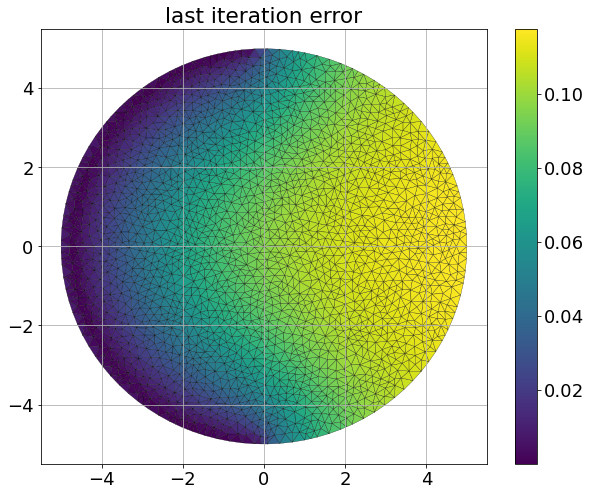

In [15]:
# test 3, u = exp(-t) + t * r * cos(phi)

domain = Circle(Point(0, 0), 5)
mesh = generate_mesh(domain, 32)
V = FunctionSpace(mesh, 'P', 2)

T = 5.0
num_steps = 20
dt = T / num_steps

r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

t = 0
exact_u = Expression("exp(-t) + t * r * cos(phi)", t = t, r = r, phi = phi, degree = 2)
param_a = Constant(1)
f = Expression("- exp(-t) + r * cos(phi)", t = t, r = r, phi = phi, degree = 2)
h = Expression("exp(-t) + t * 5 * cos(phi)", t = t, phi = phi, degree = 2)
g = Expression("t * cos(phi)", t = t, phi = phi, degree = 2)

u_n = interpolate(h, V)
u_list_fem = [u_n.copy()]
u_list_exact = [Expression("exp(-t) + t * r * cos(phi)", t = t, r = r, phi = phi, degree = 2)]
for n in range(num_steps):
    t += dt
    exact_u.t = t
    f.t = t
    h.t = t
    g.t = t
    u = calculate(V, exact_u, 1.0 / (dt * param_a), u_n / (dt * param_a) + f / param_a, h, g, False)
    u_n.assign(u)
    u_list_fem.append(u_n.copy())
    u_list_exact.append(Expression("exp(-t) + t * r * cos(phi)", t = t, r = r, phi = phi, degree = 2))
    
mn, mx = minimax(mesh, u_list_fem)

for i in range(num_steps):
    visualize2(mesh, i, u_list_fem[i], None, "fem solution, $u = e^{-t} + t r cos(φ)$", mn, mx, True)

with imageio.get_writer("_test_3_fem.gif", mode = 'i', duration = 0.3) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"fig_{i}.png")
        writer.append_data(image)
        
mn, mx = minimax(mesh, u_list_exact)        

for i in range(num_steps):
    visualize2(mesh, i, u_list_exact[i], None, "exact solution, $u = e^{-t} + t r cos(φ)$", mn, mx, True)

with imageio.get_writer("_test_3_exact.gif", mode = 'i', duration = 0.3) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"fig_{i}.png")
        writer.append_data(image)

visualize(mesh, u_list_fem[num_steps - 1], u_list_exact[num_steps - 1], "last iteration error")